<a href="https://colab.research.google.com/github/pragyasrivastava0805/congenial-journey/blob/main/W_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import numpy as np
import os
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image



class OfficeAmazonDataset(Dataset):


    def __init__(self, image_folder_dataset, transform=None):
        super(OfficeAmazonDataset, self).__init__()
        self.image_folder_dataset = image_folder_dataset
        self.transform = transform

    def __len__(self):
        return len(self.image_folder_dataset.imgs)

    def __getitem__(self, idx):
        # read image, class from folder_dataset given index
        img, img_label = image_folder_dataset[idx][0], image_folder_dataset[idx][1]

        # apply transformations (it already returns them as torch tensors)
        if self.transform is not None:
            self.transform(img)

        img_label_pair = {"image": img,
                         "class": img_label}

        return img_label_pair


def get_dataloader(dataset, batch_size, train_ratio=0.7):


    def get_subset(indices, start, end):
        return indices[start:start+end]

    # Split train/val data ratios
    TRAIN_RATIO, VALIDATION_RATIO = train_ratio, 1-train_ratio
    train_set_size = int(len(dataset) * TRAIN_RATIO)
    validation_set_size = int(len(dataset) * VALIDATION_RATIO)

    # Generate random indices for train and val sets
    indices = torch.randperm(len(dataset))
    train_indices = get_subset(indices, 0, train_set_size)
    validation_indices = get_subset(indices,train_set_size,validation_set_size)
    # test_indices = get_subset(indices,train_count+validation_count,len(dataset))

    # Create sampler objects
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(validation_indices)

    # Create data loaders
    train_loader = DataLoader(dataset, batch_size=batch_size,
                              sampler=train_sampler, num_workers=0)

    val_loader = DataLoader(dataset, batch_size=batch_size,
                            sampler=val_sampler, num_workers=0)

    return train_loader, val_loader


def get_office_data(name_dataset):


    
    root_dir = "/content/drive/My Drive/Original_images/Original_images" .format(name_dataset)

    __datasets__ = ["amazon", "dslr", "webcam"]

    if name_dataset not in __datasets__:
        raise ValueError("must introduce one of the three datasets in office")

    mean_std = {
        "amazon":{
            "mean":[0.7923, 0.7862, 0.7841],
            "std":[0.3149, 0.3174, 0.3193]
        },
        "dslr":{
            "mean":[0.4708, 0.4486, 0.4063],
            "std":[0.2039, 0.1920, 0.1996]
        },
        "webcam":{
            "mean":[0.6119, 0.6187, 0.6173],
            "std":[0.2506, 0.2555, 0.2577]
        }
    }

    # compose image transformations
    data_transforms = transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.CenterCrop(227),
            # transforms.RandomSizedCrop(224),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_std[name_dataset]["mean"],
                                 std=mean_std[name_dataset]["std"])
        ])

    # retrieve dataset using ImageFolder
    # datasets.ImageFolder() command expects our data to be organized
    # in the following way: root/label/picture.png
    dataset = datasets.ImageFolder(root=root_dir,
                                   transform=data_transforms)
    # Dataloader is able to spit out random samples of our data,
    # so our model won’t have to deal with the entire dataset every time.
    # shuffle data when training
  
    return dataset

In [ ]:
source_train_loader,source_val_loader=get_dataloader(get_office_data("webcam"),batch_size=64,train_ratio=0.70)
target_train_loader,target_val_loader=get_dataloader(get_office_data("dslr"),batch_size=64,train_ratio=0.70)

In [ ]:
from torch.autograd import Function
import torch.nn as nn
import torchvision.models as models
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        
        resnetModel = models.resnet50(pretrained=True)
        feature_map = list(resnetModel.children())
        feature_map.pop()
        for layers in feature_map:
          layers.trainable=False
        self.feature_extractor = nn.Sequential(*feature_map)

        self.classifier = nn.Sequential(
            nn.Linear(2048, 31),
        )

        self.discriminator = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 32),
        )

    def forward(self, input_data, alpha):
        input_data = input_data.expand(input_data.data.shape[0], 3, 227, 227)
        feature = self.feature_extractor(input_data)
        feature = feature.view(-1, 2048)

        reverse_bottleneck = ReverseLayerF.apply(feature, alpha)

        class_output = self.classifier(feature)
        domain_output = self.discriminator(reverse_bottleneck)

        return class_output, domain_output

In [ ]:
def test(dataloader):
    len_dataloader = len(dataloader)
    data_target_iter = iter(dataloader)

    i = 0
    n_total = 0
    n_correct = 0
    while i < len_dataloader:

        # test model using target data
        data_target = data_target_iter.next()
        t_img, t_label = data_target

        batch_size = len(t_label)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)


        input_img.resize_as_(t_img).copy_(t_img)
        class_label.resize_as_(t_label).copy_(t_label)

        class_output, _ = my_net(input_data=input_img, alpha=alpha)
        pred = class_output.data.max(1, keepdim=True)[1]
        n_correct += pred.eq(class_label.data.view_as(pred)).cpu().sum()
        n_total += batch_size

        i += 1
    accu = n_correct.data.numpy() * 1.0 / n_total
    return accu

In [ ]:
lr = 1e-3
n_epoch=10
my_net = ResNet50()
import torch.optim as optim
optimizer = optim.Adam(my_net.parameters(), lr=lr)
image_size=227
acc1=[]
acc2=[]

loss_class = torch.nn.CrossEntropyLoss()
loss_domain = torch.nn.CrossEntropyLoss()

for p in my_net.parameters():
    p.requires_grad = True
for epoch in range(n_epoch):

    len_dataloader = min(len(source_train_loader), len(target_train_loader))
    data_source_iter = iter(source_train_loader)
    data_target_iter = iter(target_train_loader)

    i = 0
    while i < len_dataloader:

        
        alpha = 1

        # training model using source data
        data_source = data_source_iter.next()
        s_img, s_label = data_source
      
        my_net.zero_grad()
        batch_size = len(s_label)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)
    

     

        input_img.resize_as_(s_img).copy_(s_img)
        class_label.resize_as_(s_label).copy_(s_label)

        class_output, domain_output = my_net(input_data=input_img, alpha=alpha)
        err_s_label = loss_class(class_output, class_label)
        err_s_domain = loss_domain(domain_output, class_label)

        # training model using target data
        data_target = data_target_iter.next()
        t_img, _ = data_target

        batch_size = len(t_img)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        domain_label = torch.full((batch_size,1),31)
        domain_label.squeeze_()

      

        input_img.resize_as_(t_img).copy_(t_img)

        _, domain_output = my_net(input_data=input_img, alpha=alpha)
        err_t_domain = loss_domain(domain_output, domain_label)
        err = (err_t_domain + err_s_domain)/(len(source_train_loader)+len(target_train_loader)) + err_s_label/(len(source_train_loader))
        err.backward()
        optimizer.step()

        i += 1
    print(epoch,n_epoch, err_s_label.cpu().data.numpy(),err_s_domain.cpu().data.numpy(), err_t_domain.cpu().data.numpy())
    acc1.append(test(source_val_loader))
    acc2.append(test(target_val_loader))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0 10 0.0837978 1.3358656 0.6649173
1 10 0.0658206 1.0444944 0.6706693
2 10 0.26626378 1.1511894 0.7364802
3 10 0.15791075 0.8853248 0.829731
4 10 0.16390583 0.95027155 0.72230285
5 10 0.26298577 0.9609374 0.70877945
6 10 0.1972064 1.4047852 0.6173439
7 10 0.122759275 0.8333171 0.8317548
8 10 0.010378698 0.6668774 0.75334275
9 10 0.0625501 0.9004926 0.70466745


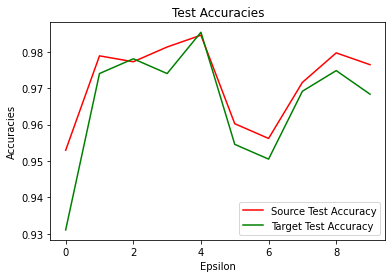

0.9764801297648013 0.9683698296836983


In [ ]:
import matplotlib.pyplot as plt
epsilon=np.arange(0,10,1)
plt.plot(epsilon,acc1,color='r',label='Source Test Accuracy')
plt.plot(epsilon,acc2,color='g',label='Target Test Accuracy')

plt.xlabel("Epsilon")



plt.ylabel("Accuracies")
plt.title("Test Accuracies")
plt.legend()
  

plt.show()
print(acc1[len(acc1)-1],acc2[len(acc2)-1]) 
